# Multi-Class Tree:
A Basic Implementation of Multi-Class Tree Model with Explainability which includes:
- Preprocessing and encoding data
- Training a XGBoost Model
- Evaluating predictions of Multi-Class threats.
- Integrating the results into shap using the SHAP Manager Class.

In [1]:
# Check the working directory and set it to the main folder if needed.
# Set the directory to the main directory for imports.
import os
os.getcwd()

'c:\\Users\\adi_s\\Desktop\\LSTM\\UserGuides'

In [2]:
# Changing to main directory for Module imports.
os.chdir('../')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

We use the full dataset for Random Forest Multi-Class otherwise errors might occur due to some labels having no correct predictions.

In [4]:
# Preprocess.
data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# A little bit of extra cleaning.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_37332\62178567.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')


The Tree Models are robust and do not require one-hot encoding. One-hot encoding and Label encoding usually yield the same results in the models. A requirement for the Random Forest is to label encode categories. Other models such as Cat-Boost can handle native string values. Here we will label encode the data and for each encoded feature store the encoder in a list so we can inverse transform them in shap. Here it is important to also encode the labels because of how shap integrates with it. If we use the string values it might be difficult to figure out in which order the Random Forest has put the labels.

In [5]:
# Label encode data2 (standard).
cols = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
data[cols] = data[cols].astype(str)
le_features = []
for c in cols:
    le = LabelEncoder()
    data[c] = le.fit_transform(data[c])
    le_features.append(le)
# Keep label seperate for simplicity
le_label = LabelEncoder()
data['attack_cat'] = le_label.fit_transform(data['attack_cat'])

We split the data and drop the label columns from the X sets and use attack_cat the multi-class label as our labels.

In [6]:
X_temp = data.drop(columns=['label', 'attack_cat'])
y1 = data['attack_cat']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y1, test_size=0.2, random_state=42)

For the purpose of this example we reduce the number of estimators which speeds up the shap value and explainer calculations but usually leads to lower accuracy overall. We use ana XGBoost model because the Random Forest tends to crash the kernel on multi-class shap value calculations.

In [7]:
xgb = XGBClassifier(n_estimators=10, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9801952717466191
              precision    recall  f1-score   support

           0       0.50      0.03      0.06       550
           1       0.84      0.07      0.12       477
           2       0.41      0.24      0.30      3315
           3       0.61      0.86      0.71      8732
           4       0.68      0.42      0.52      4784
           5       1.00      0.98      0.99     43110
           6       0.99      1.00      1.00    443831
           7       0.92      0.79      0.85      2850
           8       0.63      0.62      0.63       320
           9       0.60      0.07      0.13        41

    accuracy                           0.98    508010
   macro avg       0.72      0.51      0.53    508010
weighted avg       0.98      0.98      0.98    508010

[[    17      0    107    354      0      1     71      0      0      0]
 [     0     32    111    323      2      0      2      4      3      0]
 [     0      1    799   2341     18     48     60     17     31  

We choose the baseline accuracy of either the test or train set. We might be better of using the training data if we wanted to try and use shap to feature engineer the data using explainability. But I am not certain about this. The Tree explainer is extremely efficient and does not require a background like the Neural Network. Infact using a background will likely slow down the calculation of shap values and cause additivity errors.

In [9]:
# We create a smaller sample to speed up the visualisations for the example.
sample = X_test.sample(n=10000)
sample = sample.reset_index(drop=True)

In [10]:
xp = shap.TreeExplainer(xgb)

We get the values for both the Explainer object for cohorts and base values and the shap values.

In [11]:
explainer = xp(sample)

In [12]:
from Tools.shap_manager import SHAPmanager
# read docs.
help(SHAPmanager)

Help on class SHAPmanager in module Tools.shap_manager:

class SHAPmanager(builtins.object)
 |  SHAPmanager(explainer, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |
 |  SHAPmanager: A wrapper that handles multiple shap evaluation tasks. Automatically links the variable names to the correct shap array, handles differing parameters for
 |  visualisations, has grouping functions for ordinal and one hot encoded features, filtering of features, selecting labels, and restoring the data to the original form.
 |  Makes managing tasks easy without the large overhead of coding indexes.
 |
 |  Known Errors:
 |      - After restoring data make sure to set the label in multiclass using change_label function.
 |
 |  NOTE: This is a working progress..
 |
 |  Methods defined here:
 |
 |  __init__(self, explainer, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |      Initiaisation: Handles different typ

When initialising the SHAPmanager class for multi class the label_type needs to be set to multi and the label encoders for the features and target label must be provided along with the set_label parameter which sets it the class being evaluated. The label encoder automatically maps it to the correct class based on the original string name given in set_label.

In [13]:
# set label type to multi for multi-class data.
label_type = 'multi'
# Make sure to add the label and feature encoder used earlier.
# Provide the label category to be evaluated.
set_label = 'DoS'
sm = SHAPmanager(explainer, label_type=label_type, feature_encoder=le_features, label_encoder=le_label, set_label=set_label)

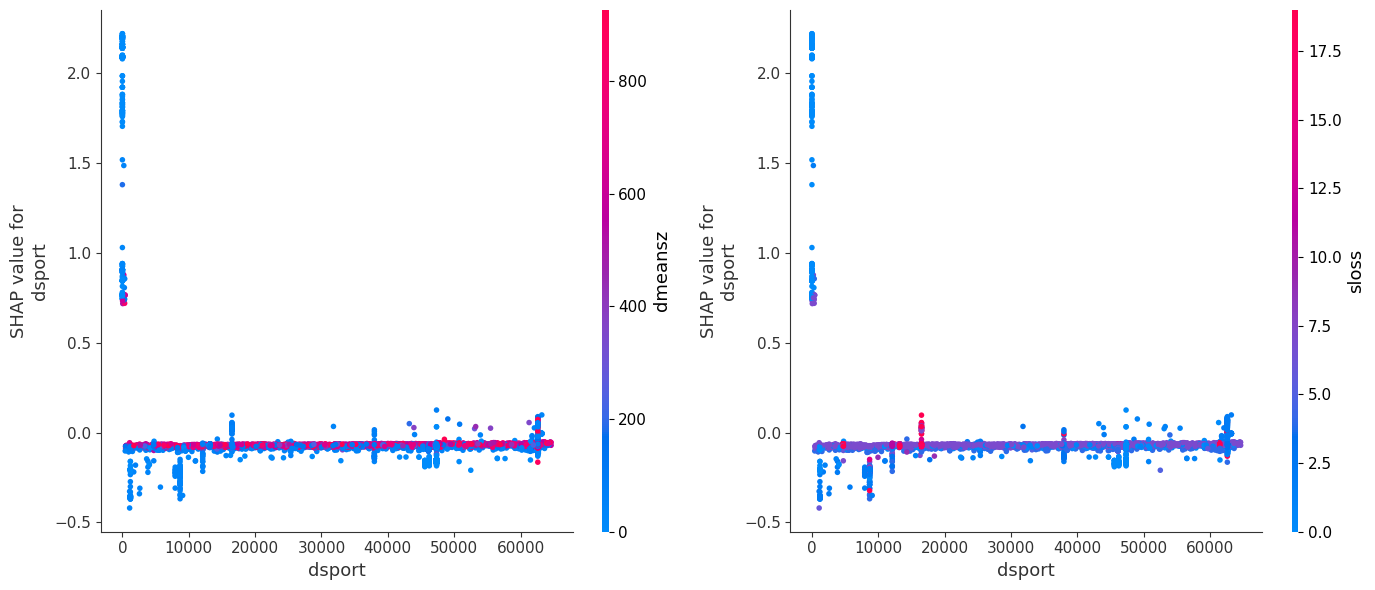

In [14]:
# The variable to check interactions for the given label.
variable = 'dsport'
# The number of interactions to approximate. Can be set to 1 for the highest interaction feature or multiples of 2 for subplots.
n_interaction = 2
sm.plot_dependence(variable=variable, n_interaction=n_interaction)

We can run a standard summary plot to get an overview of feature importance. This also shows the individual points which are generated using a random jitter function. This means they are in the correct position on the X-axis but are distributed throughout the Y-axis for interpretability.

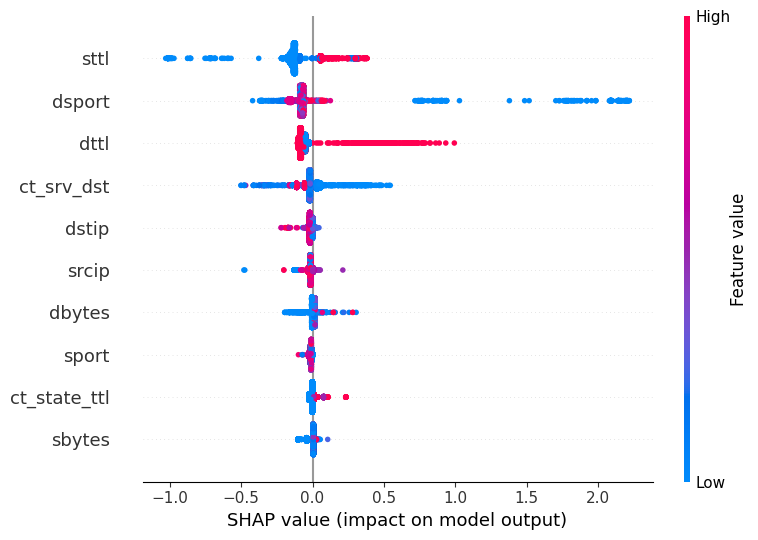

In [15]:
# We can set the maximum number of features to view.
max_features = 10
sm.plot_summary(max_features=max_features)

We can also plot specific features when wanting to compare multiple plots. The summary plot will still order them by greatest shap values though.

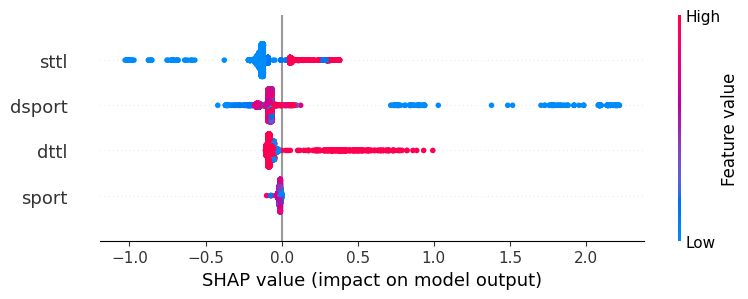

In [16]:
# Create a list of features.
features = ['sport', 'dsport', 'dttl', 'sttl']
sm.plot_summary(features=features)

It is also possible to make comparisons between different labels based on the absolute average shapely value. This shows the contribution of shapely values for each label.

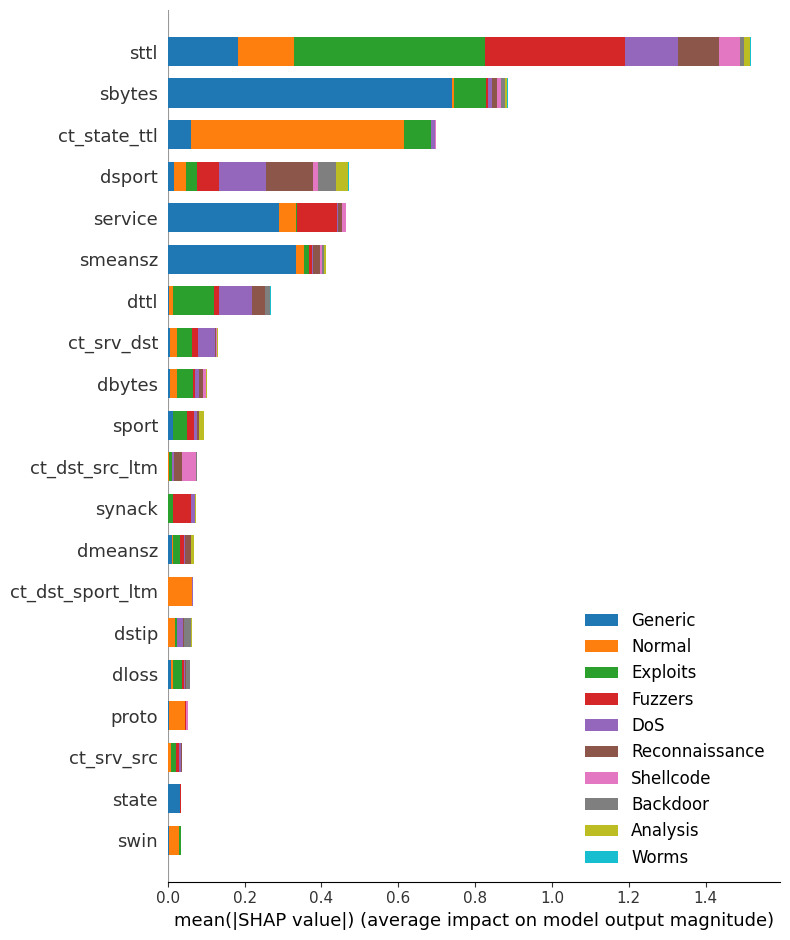

In [17]:
# Max features is not currently available in the legacy summary plots.
# Set the multi parameter. Using 'All' shows a comparison for each label. The label names are automatically mapped into the plot.
multi = 'All'
sm.plot_summary(multi=multi)

Alternatively create a summary plot between specific labels. The comparison is being made with the current label set and the labels provided in a list. Lets change the label and make a new plot. Here we need to keep in mind the range of SHAP values to make sure we don't misinterpret it.

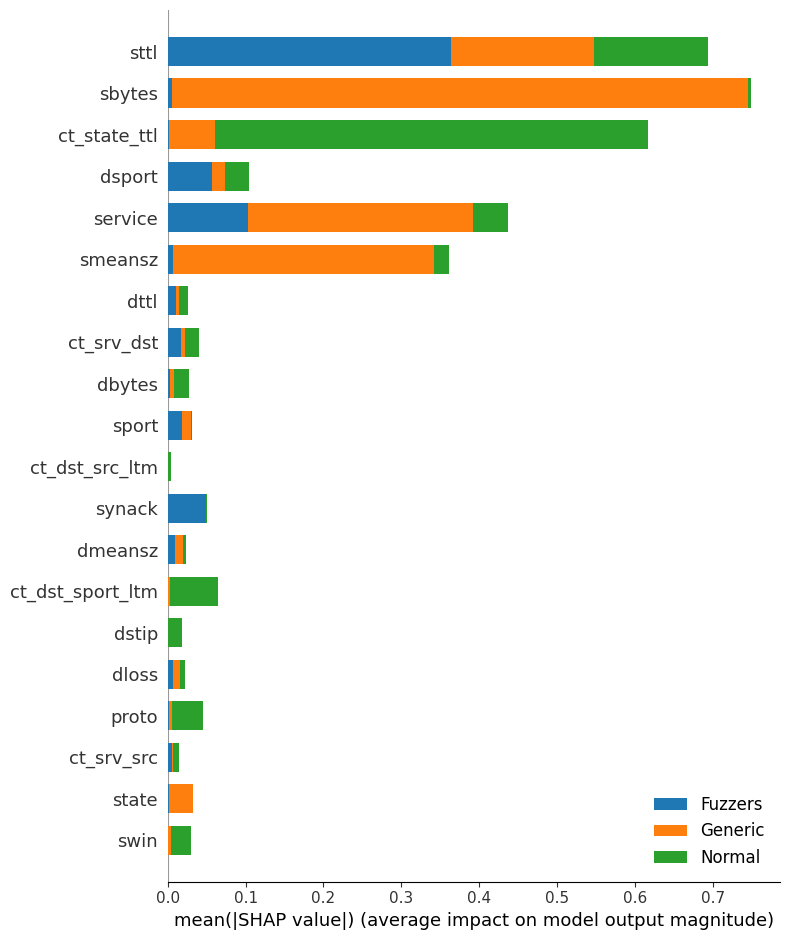

In [18]:
# Change the label to Fuzzers.
sm.set_label('Fuzzers')
# Create a list of the other labels to compare.
labels = ['Generic', 'Normal']
sm.plot_summary(multi=labels)

The dependence plot shows the interactions for the features in the current label (Fuzzers). The function automatically finds the strongest interaction based on the approximate interaction function. But a specific feature can also be set. The function is based on the shap API and includes all the parameters but also includes a few more to simplify indexing tasks.

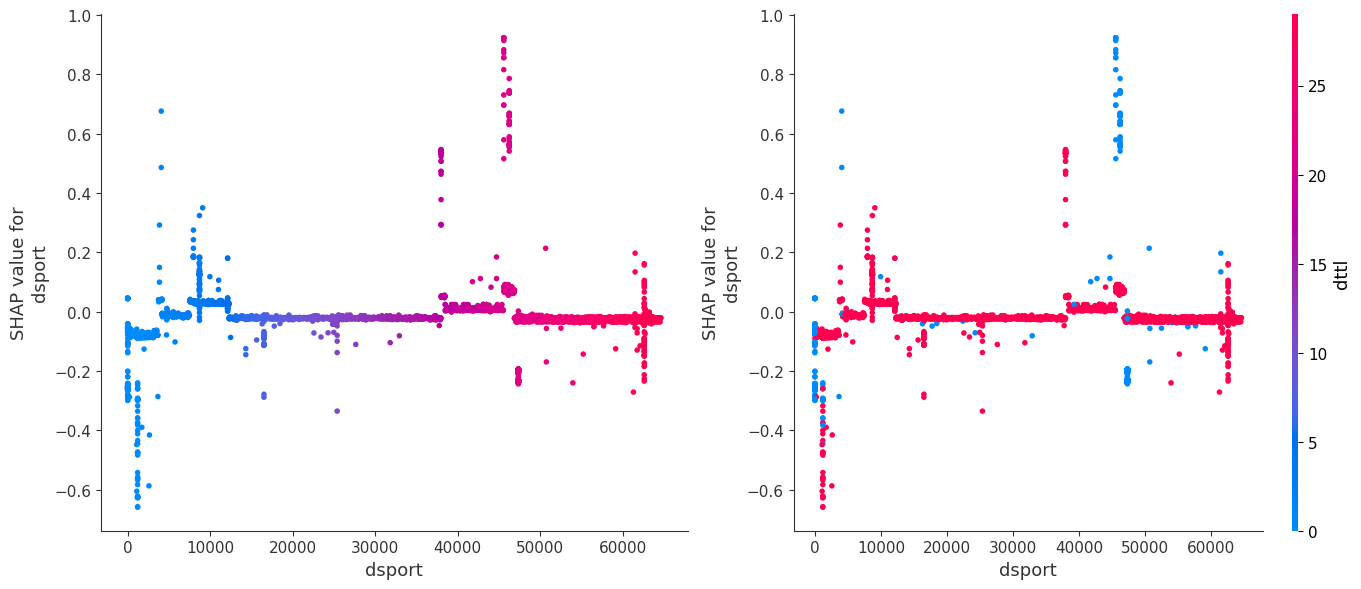

In [19]:
# The variable to check interactions for the given label.
variable = 'dsport'
# The number of interactions to approximate. Can be set to 1 for the highest interaction feature or multiples of 2 for subplots.
n_interaction = 2
sm.plot_dependence(variable=variable, n_interaction=n_interaction)

We can also specify an interaction to view.

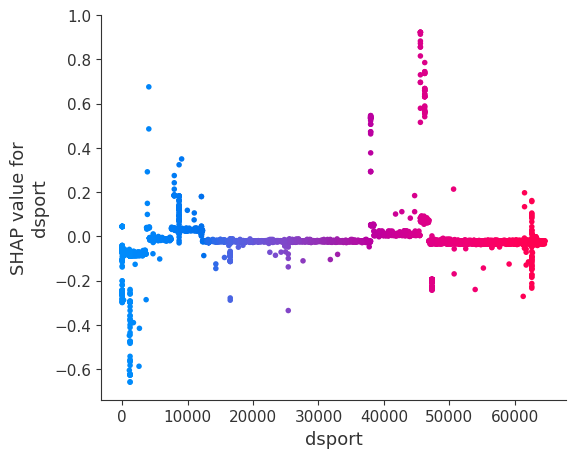

In [20]:
# The variable to check interactions for the given label.
variable = 'dsport'
# The variable to use for interaction index. If it is the same variable the name won't show up on the right y-axis.
specific_interaction='dsport'
sm.plot_dependence(variable=variable, specific_interaction=specific_interaction)

Sometimes for Tree Models that use label encoding we might want to view the actual strings of the values instead of the label encoded values. To do this we can use the string encode function. A list needs to be provided of the variables which map exactly to the Label Encoder provided.

In [21]:
# The variables encoded earlier.
categories = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
sm.string_encode(categories)

Now lets replot destination ports to see how they appear. An Error occurs because of the large amount of unique values. The dependency plot automatically registers it as a category variable and tries to provide a position for it in the plot.

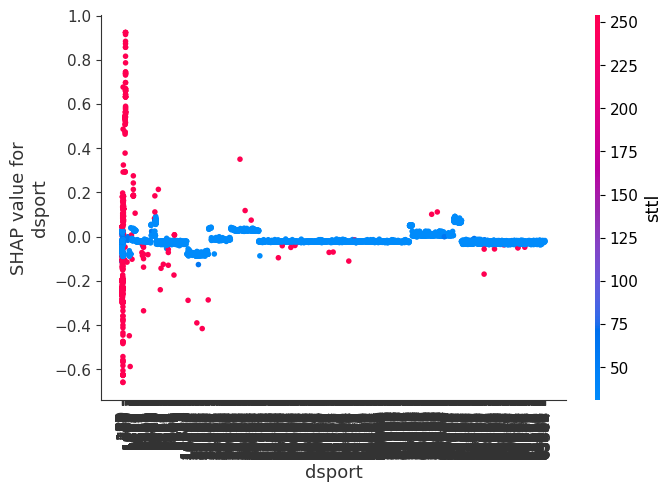

In [22]:
# The variable to check interactions for the given label.
variable = 'dsport'
# The variable to use for interaction index.
specific_interaction='sttl'
sm.plot_dependence(variable=variable, specific_interaction=specific_interaction)

This can be fixed by using the custom group function which creates a group based on the highest absolute average shap value for each unique value in the variable. We will select the top 20 and all other values will be automatically set to 'Other'.

NOTE: For this function to work the string encode function must be used beforehand.

In [23]:
# The type_of function also allows you to specify the values to encode instead of using the absolute average shap value by using label-encoded-specific and providing
# the values as a list in the category parameter. Here we will just use the standard mode.
type_of = 'label-encoded'
# The variable to transform.
category = 'dsport'
# The maximum number of values to convert.
limit = 20
# The calculation to use (either average or sum). The average is recommended and set as the default.
calculation = 'average'
sm.custom_group('dsport', type_of=type_of, limit=limit, calculation=calculation)

Now lets replot to see how it looks. We can also add a custom colour using cmap colours to make it a bit more interpretable for categorical feature comparisons.

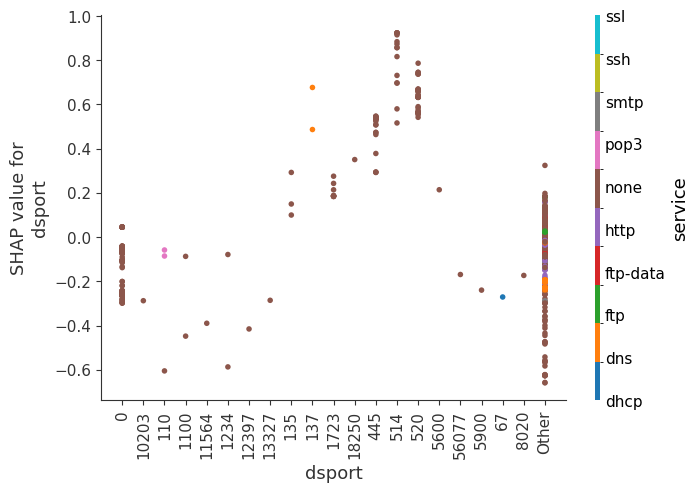

In [24]:
# The variable to check interactions for the given label.
variable = 'dsport'
# The variable to use for interaction index.
specific_interaction='service'
sm.plot_dependence(variable=variable, specific_interaction=specific_interaction, colour='tab20')

We see a large number of shap values in 'Other' far away from 0. This means we might want to scale it up further to plot them. First we need to reset the data and go through the steps again.

In [25]:
# Restore to the original data.
sm.restore_data()
# After restoring we must set the label again.
sm.set_label('Fuzzers')

Now we string encode again and use the group function but this time set it to a higher limit of 30.

In [26]:
# The variables encoded earlier.
categories = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
sm.string_encode(categories)
type_of = 'label-encoded'
# The variable to transform.
category = 'dsport'
# The maximum number of values to convert.
limit = 30
# The calculation to use (either average or sum). The average is recommended and set as the default.
calculation = 'average'
sm.custom_group('dsport', type_of=type_of, limit=limit, calculation=calculation)

As we can see now there are a much smaller amount of shap values in Other far from 0 which is what we want to see. Essentially what we are doing is placing low shap value importance in others and viewing the other points.

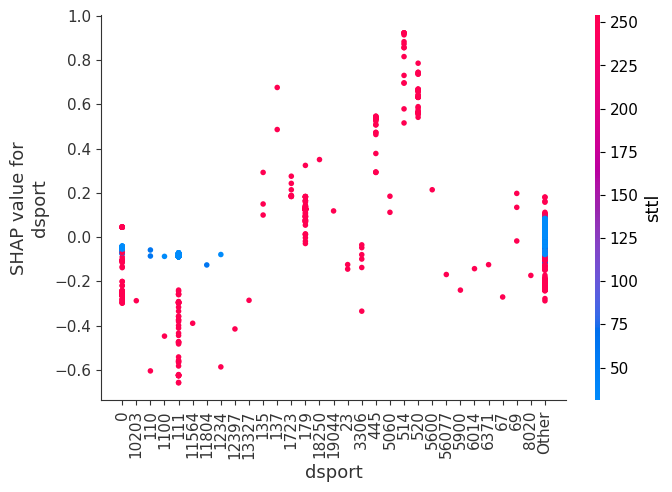

In [27]:
# The variable to check interactions for the given label.
variable = 'dsport'
# The variable to use for interaction index.
specific_interaction='sttl'
sm.plot_dependence(variable=variable, specific_interaction=specific_interaction)